In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.Util.param_util import ellipticity2phi_q
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
#from lenstronomy.Data.coordinates import Coordinates
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import lens_plot

In [2]:
background_rms = 0.05  # background noise per pixel
exp_time = 100         # exposure time
fwhm = 0.1             # full-width-half-maximum of the PSF
num_pix = 100          # number of pixels per axis
delta_pix = 0.05       # pixel size in arcseconds
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# parameters of the deflector lens model
# Lens model (Singular Isothermal Ellipsoid, SIE)
kwargs_sie = {
    'theta_E': 1.0,  # Einstein radius in arcseconds
    'e1': 0.1,  # Ellipticity component 1
    'e2': 0.1,  # Ellipticity component 2
    'center_x': 0.0,  # X-coordinate of the lens center
    'center_y': 0.0  # Y-coordinate of the lens center
}

# Source light model (Sersic profile)
kwargs_sersic = {
    'amp': 1.0,       # Amplitude of the light profile
    'R_sersic': 0.2,  # Effective radius of the Sersic profile
    'n_sersic': 1.0,  # Sersic index (n=1 is an exponential profile)
    'e1': -0.1, 
    'e2': 0.1, 
    'center_x': 0.0,  # X-coordinate of the source center
    'center_y': 0.0   # Y-coordinate of the source center
}

kwargs_sersic_lens = {
    'amp': 16, 
    'R_sersic': 0.6, 
    'n_sersic': 2, 
    'e1': -0.1, 
    'e2': 0.1, 
    'center_x': 0.05, 
    'center_y': 0
}


kwargs_source = [kwargs_sersic]
kwargs_lens = [kwargs_sie]
kwargs_lens_light = [kwargs_sersic_lens]

# Define the lens and source models
lens_model_list = ['SIE']               
source_model_list = ['SERSIC_ELLIPSE']  # Source light model type
lens_light_model_list = ['SERSIC_ELLIPSE']

lens_model_class = LensModel(lens_model_list)
source_model_class = LightModel(light_model_list=source_model_list)
lens_light_model_class = LightModel(lens_light_model_list)


kwargs_model = {
    'lens_model_list': lens_model_list,
    'source_light_model_list': source_model_list
}

In [3]:
from lenstronomy.Util import util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.ImSim.image_model import ImageModel


# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)


kwargs_data = {'background_rms': background_rms,         # rms of background noise
               'exposure_time': exp_time,                # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,                 # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,               # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,        # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((num_pix, num_pix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }
data_class = ImageData(**kwargs_data)

kwargs_psf = {
    'psf_type': psf_type, 
    'fwhm': fwhm, 
    'pixel_size': delta_pix, 
    'truncation': 3
}
psf_class = PSF(**kwargs_psf)

kwargs_numerics = {
    'supersampling_factor': 1, 
    'supersampling_convolution': False}

imageModel = ImageModel( 
    data_class = data_class, 
    psf_class = psf_class, 
    lens_model_class = lens_model_class,                     
    source_model_class = source_model_class, 
    lens_light_model_class = lens_light_model_class,
    kwargs_numerics = kwargs_numerics
)

image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)



/var/folders/bn/sb0tt86947905bxwkyc0177r0000gn/T/ipykernel_23031/3971612899.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad(color='k', alpha=1.)
/var/folders/bn/sb0tt86947905bxwkyc0177r0000gn/T/ipykernel_23031/3971612899.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_under('k')


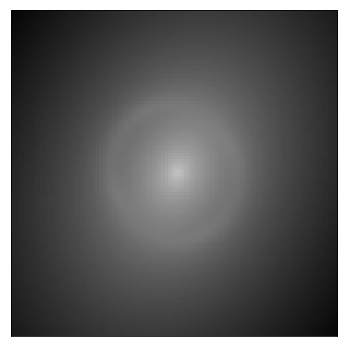

In [4]:
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

ax = axes
im = ax.matshow(np.log10(image_model), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()